In [2]:
#Loading the original tables into dataframes
#df_accident=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1979-2021.csv', sep=',', header=0)
#df_vehicle=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-vehicle-1979-2021.csv', sep=',', header=0)
#df_casualty=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-casualty-1979-2021.csv', sep=',', header=0)

In [87]:
import pygeohash as gh
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.dirname(sys.path[0]))

from python.data_cleaning import prepare_data_for_groupby
from python.grouped_data import data_for_analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Filtering the dataframes to get dta from 1999 only
#df_accident_1999=df_accident[df_accident['accident_year']>=1999]
#df_vehicle_1999=df_vehicle[df_vehicle['accident_year']>=1999]
#df_casualty_1999=df_casualty[df_casualty['accident_year']>=1999]

In [3]:
#Exporting the data from 1999 as csv files --> the new raw data files
#df_accident_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv')
#df_vehicle_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-vehicle-1999-2021.csv')
#df_casualty_1999.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-casualty-1999-2021.csv')

In [4]:
df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv', index_col=0)
df_accidents.head()

/tmp/ipykernel_31702/1322138315.py:1: DtypeWarning: Columns (1,3,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-1999-2021.csv', index_col=0)


,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
4883216,1999010SU0945,1999,010SU0945,519490.0,203300.0,-0.271752,51.715661,1,3,1,...,0,1,4,1,0,0,2,1,1,E01023583
4883217,1999010SU0946,1999,010SU0946,521740.0,201070.0,-0.239977,51.695136,1,3,2,...,0,6,4,1,0,0,2,1,1,E01023584
4883218,1999010SU0947,1999,010SU0947,519610.0,203240.0,-0.270037,51.715096,1,3,2,...,0,4,1,2,0,0,2,1,1,E01023583
4883219,1999010SU0948,1999,010SU0948,520090.0,202830.0,-0.263233,51.711309,1,2,2,...,0,6,1,1,0,0,2,1,1,E01023583
4883220,1999010SU0949,1999,010SU0949,522640.0,200320.0,-0.227225,51.688200,1,3,4,...,0,1,1,2,0,0,2,1,1,E01023584


In [57]:
#Creating a small dataset to be loaded quickly
df_accidents_small=df_accidents[df_accidents['accident_year']==2019]
df_accidents_small.to_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-small.csv')

In [66]:
test=prepare_data_for_groupby(df_accidents,6)

In [67]:
test_data=data_for_analysis(test,granularity='W')
test_data.head(52)

,Accidents
date,
1998-12-29/1999-01-04,1586
1999-01-05/1999-01-11,4623
1999-01-12/1999-01-18,5000
1999-01-19/1999-01-25,4589
1999-01-26/1999-02-01,4137
1999-02-02/1999-02-08,3986
1999-02-09/1999-02-15,4320
1999-02-16/1999-02-22,3902
1999-02-23/1999-03-01,4321


In [68]:
test_data.shape

(1201, 1)

In [69]:
hashes=pd.DataFrame(test[['geohash','accident_year']].groupby('geohash').count())
hashes.columns=['Accidents']
hashes.sort_values('Accidents',inplace=True,ascending=False)
hashes.shape


(184578, 1)

In [70]:
hashes.describe()

,Accidents
count,184578.000000
mean,20.676852
std,57.175713
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,2045.000000


In [71]:
hashes[hashes['Accidents']>=100]

,Accidents
geohash,
gcpvj0,2045
gcpvhc,1959
gcpvj4,1871
gcpvj1,1816
gcpuv2,1744
...,...
gcwzyg,100
gcx6bn,100
u120gg,100


In [74]:
#Isolating the square where there are more accidents
max_square=hashes[hashes['Accidents']==hashes.Accidents.max()].index[0]
max_square

'gcpvj0'

In [206]:
#Filtering the data for the max_square
test_max_square=test[test['geohash']==max_square]
test_max_square.shape

(2045, 13)

In [81]:
test_data_max_square=data_for_analysis(test_max_square,'W')
test_data_max_square.head(50)

,Accidents
date,
1998-12-29/1999-01-04,1
1999-01-05/1999-01-11,1
1999-01-12/1999-01-18,1
1999-01-19/1999-01-25,1
1999-01-26/1999-02-01,1
1999-02-02/1999-02-08,4
1999-02-09/1999-02-15,3
1999-02-16/1999-02-22,5
1999-02-23/1999-03-01,2


In [120]:
FOLD_LENGTH=156 #each fold spans over 3 years
FOLD_STRIDE=52 #we have a  fold every 1 year

In [84]:
def get_folds(
    df,
    fold_length,
    fold_stride):
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    Returns a list of folds, each as a DataFrame
    '''
    folds=[]
    for index in range(0,df.shape[0]-fold_length,fold_stride):
        fold=df[index:index+fold_length]
        folds.append(fold)
    return folds

In [121]:
folds=get_folds(test_data_max_square,FOLD_LENGTH,FOLD_STRIDE)
np.array(folds).shape

(21, 156, 1)

In [122]:
fold1=folds[0]

In [169]:
INPUT_LENGTH=20 #every X_i sequence is 20 weeks long
TRAIN_TEST_RATIO=.66 #in each fold, we use 2 years for training and 1 year for test
OUTPUT_LENGTH=20 #we want to predict the number of accidents in the next 20 weeks (y_i length)

In [103]:
def train_test_split(fold,
                     train_test_ratio,
                     input_length):
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    # TRAIN SET
    last_train_idx = round(train_test_ratio * len(fold))
    train_fold = fold.iloc[0:last_train_idx, :]
    

    # TEST SET
    first_test_idx = last_train_idx - input_length
    test_fold = fold.iloc[first_test_idx:, :]
    
    return (train_fold, test_fold)

In [119]:
(fold1_train, fold1_test) = train_test_split(fold1, TRAIN_TEST_RATIO, INPUT_LENGTH)
fold1_train.shape

(103, 1)

In [108]:
SEQUENCE_STRIDE = 1
TARGET='Accidents'

In [109]:
def get_X_y_strides(fold, input_length, output_length, sequence_stride):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) > len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [170]:
X_train1, y_train1 = get_X_y_strides(fold1_train,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)

In [171]:
X_train1.shape

(64, 20, 1)

In [172]:
X_test1, y_test1 = get_X_y_strides(fold1_test,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)

In [173]:
X_test1.shape

(34, 20, 1)

In [113]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization

2022-12-07 12:15:14.669102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 12:15:15.198079: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-07 12:15:15.198102: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-07 12:15:17.852332: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [215]:
def init_model(X_train):
    
    # 0 - Normalization    
    #normalizer = Normalization()
    #normalizer.adapt(X_train)
    
    # 1 - RNN architecture   
    model = models.Sequential()
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    #model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(20, 
                          activation='tanh', 
                          return_sequences = True,
                          recurrent_dropout = 0.3,
                          input_shape=X_train[0].shape))
    ## 1.2 - Predictive Dense Layers
    model.add(layers.Dense(1, activation='linear'))

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])
    
    return model

In [216]:
model = init_model(X_train1)
model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 20, 20)            1760      
                                                                 
 dense_28 (Dense)            (None, 20, 1)             21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [176]:
from tensorflow.keras.callbacks import EarlyStopping

def fit_model(model, X_train, y_train, verbose=1):

    es = EarlyStopping(monitor = "val_loss",
                      patience = 3,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [217]:
model, history = fit_model(model,X_train1,y_train1)

Epoch 1/50
2/2 [==============================] - 4s 572ms/step - loss: 11.0372 - mae: 2.8784 - val_loss: 8.5503 - val_mae: 2.2065
Epoch 2/50
2/2 [==============================] - 0s 87ms/step - loss: 5.0101 - mae: 1.7240 - val_loss: 5.4330 - val_mae: 1.7398
Epoch 3/50
2/2 [==============================] - 0s 93ms/step - loss: 3.3840 - mae: 1.3738 - val_loss: 5.0833 - val_mae: 1.8204
Epoch 4/50
2/2 [==============================] - 0s 100ms/step - loss: 3.5344 - mae: 1.4673 - val_loss: 4.9679 - val_mae: 1.8122
Epoch 5/50
2/2 [==============================] - 0s 100ms/step - loss: 3.4640 - mae: 1.4599 - val_loss: 4.8156 - val_mae: 1.7521
Epoch 6/50
2/2 [==============================] - 0s 100ms/step - loss: 3.1787 - mae: 1.3793 - val_loss: 4.8127 - val_mae: 1.6804
Epoch 7/50
2/2 [==============================] - 0s 87ms/step - loss: 3.0229 - mae: 1.2963 - val_loss: 4.9531 - val_mae: 1.6638
Epoch 8/50
2/2 [==============================] - 0s 108ms/step - loss: 2.9926 - mae: 1.2801

In [222]:
model.predict(X_test1).shape

2/2 [==============================] - 0s 8ms/step


(34, 20, 1)

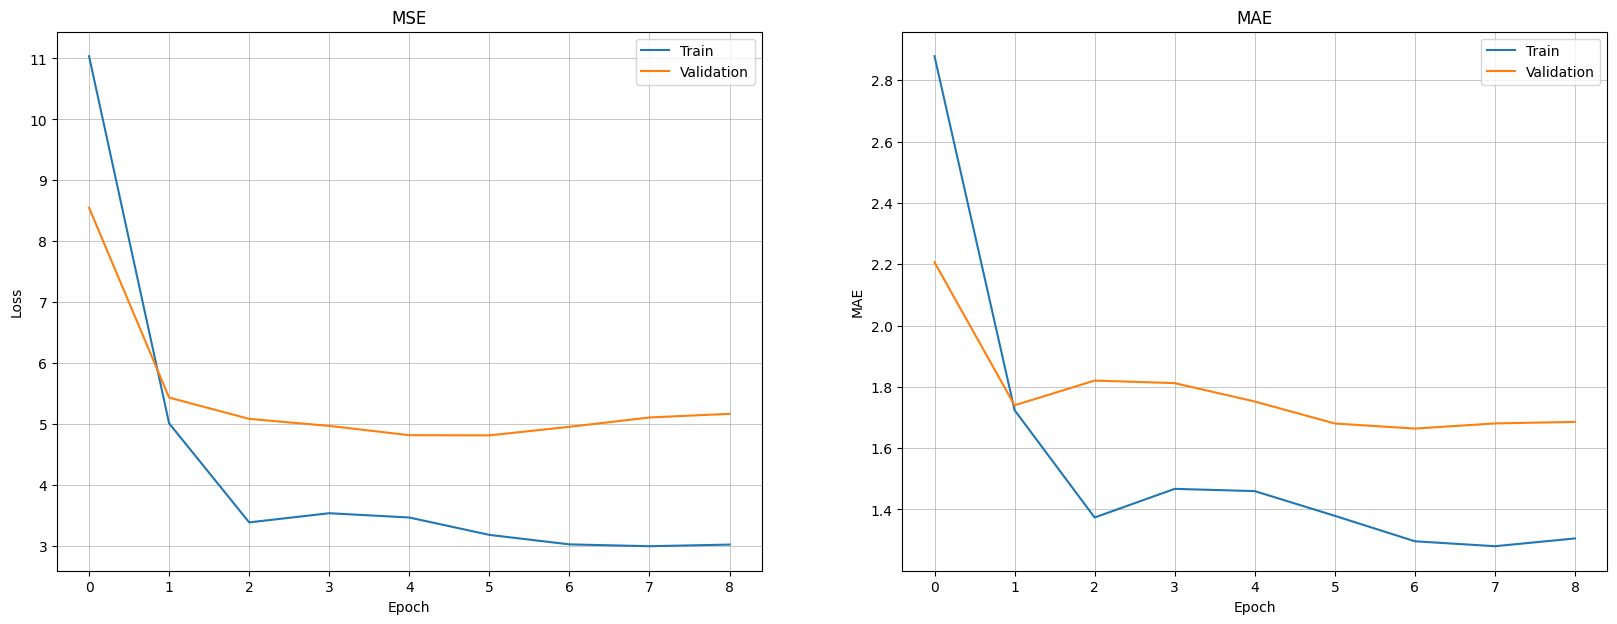

In [218]:
plot_history(history);

In [219]:
res=model.evaluate(X_test1,y_test1)

2/2 [==============================] - 0s 13ms/step - loss: 3.1044 - mae: 1.4869


In [136]:
from tensorflow.keras.layers import Lambda

def init_baseline():

    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-OUTPUT_LENGTH:,0,None]))

    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

In [183]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test1, y_test1)

2/2 [==============================] - 0s 7ms/step - loss: 4.1176 - mae: 1.8618


In [202]:
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} accidents")
print(f"Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} %")

The LSTM MAE on the test set is equal to 1.66 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = : 10.76 %


In [197]:
from tensorflow.keras.callbacks import EarlyStopping

def cross_validate_baseline_and_lstm(df):
    '''
    This function cross-validates 
    - the "last seen value" baseline model
    - the RNN model
    '''
    
    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []
    
    # 0 - Creating folds
    # =========================================    
    folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)
    print(len(folds))
    
    for fold_id, fold in enumerate(folds):
        
        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)                   

        X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
        X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
        
        # 2 - Modelling
        # =========================================
        
        ##### Baseline Model
        baseline_model = init_baseline()
        mae_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)[1]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train)
        es = EarlyStopping(monitor = "val_mae",
                           mode = "min",
                           patience = 2, 
                           restore_best_weights = True)
        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 32,
                            epochs = 50,
                            callbacks = [es],
                            verbose = 0)
        res = model.evaluate(X_test, y_test, verbose=0)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")
        
        ##### Comparison LSTM vs Baseline for the current fold
        print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model

In [220]:
%%time
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm(test_data_max_square)

21
--------------------------------------------------
MAE baseline fold n°0 = 1.86
MAE LSTM fold n°0 = 1.52
🏋🏽‍♂️ improvement over baseline: 18.13 % 

--------------------------------------------------
MAE baseline fold n°1 = 1.44
MAE LSTM fold n°1 = 1.14
🏋🏽‍♂️ improvement over baseline: 20.93 % 

--------------------------------------------------
MAE baseline fold n°2 = 1.39
MAE LSTM fold n°2 = 1.1
🏋🏽‍♂️ improvement over baseline: 20.94 % 

--------------------------------------------------
MAE baseline fold n°3 = 1.33
MAE LSTM fold n°3 = 1.1
🏋🏽‍♂️ improvement over baseline: 17.24 % 

--------------------------------------------------
MAE baseline fold n°4 = 1.35
MAE LSTM fold n°4 = 1.01
🏋🏽‍♂️ improvement over baseline: 25.03 % 

--------------------------------------------------
MAE baseline fold n°5 = 1.14
MAE LSTM fold n°5 = 0.95
🏋🏽‍♂️ improvement over baseline: 16.72 % 

--------------------------------------------------
MAE baseline fold n°6 = 1.06
MAE LSTM fold n°6 = 0.86
🏋🏽‍♂️ 

In [223]:
print(f"➡ Average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")

➡ Average percentage improvement over baseline = 20.0%
